# **Porter Delivery Time Estimation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


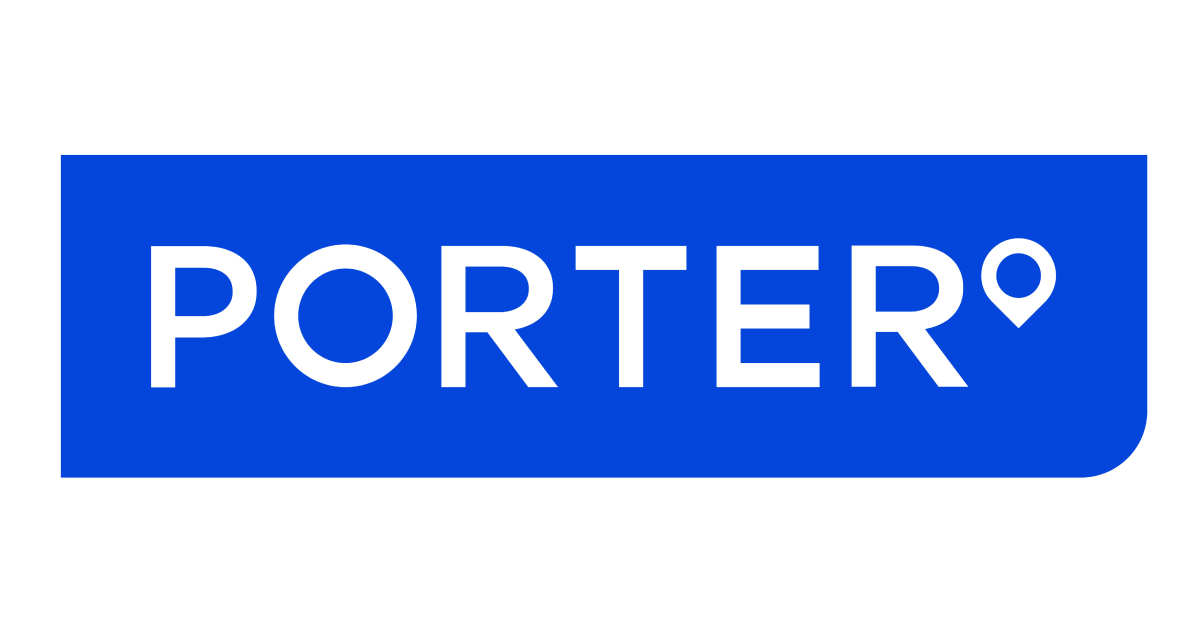

# Problem Statement
- Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

- Porter works with a wide range of restaurants for delivering their items directly to the people.

- Porter has a number of delivery partners available for delivering the food, from various restaurants and wants to get an estimated delivery time that it can provide the customers on the basis of what they are ordering, from where and also the delivery partners.

- This dataset has the required data to train a regression model that will do the delivery time estimation, based on all those features

# Data Dictionary

Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below.

- market_id : integer id for the market where the restaurant lies
- created_at : the timestamp at which the order was placed
- actual_delivery_time : the timestamp when the order was delivered
- store_primary_category : category for the restaurant
- order_protocol : integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, pre booked, third part etc)
- total_items subtotal : final price of the order
- num_distinct_items : the number of distinct items in the order
- min_item_price : price of the cheapest item in the order
- max_item_price : price of the costliest item in order
- total_onshift_partners : number of delivery partners on duty at the time order was placed
- total_busy_partners : number of delivery partners attending to other tasks
- total_outstanding_orders : total number of orders to be fulfilled at the moment

# Importing Required Libraries

In [2]:
# Importing Required Libraries.

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler,OneHotEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import cross_validate,GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization

# Importing the Dataset

In [3]:
# Connecting to google drive

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Colab Notebooks/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [4]:
# Reading the dataset

df = pd.read_csv("dataset.csv")
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


# Understanding and Cleaning Data

In [5]:
# Checking the data types of the variables.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [6]:
# Shape of the Dataset

df.shape

(197428, 14)

# Data Preprocessing

In [7]:
# Checking for duplicate records.

df.duplicated().sum()

0

In [8]:
# Since column names are lengthy, Therefore renaming them to shorter names

orignal_column_names = df.columns
new_column_names = ["m_id", "created", "delivered", "storeId", "storeCat", "orderType", "totalItems", "subtotal",
                    "distinctItems", "minItemPrice", "maxItemPrice", "onshift_p", "busy_p", "outstandingOrders"]

column_names_mapping = dict(zip(orignal_column_names, new_column_names))
df.rename(columns=column_names_mapping,inplace=True)
df.head(3)

,m_id,created,delivered,storeId,storeCat,orderType,totalItems,subtotal,distinctItems,minItemPrice,maxItemPrice,onshift_p,busy_p,outstandingOrders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0


In [9]:
# Checking for missing values percentage in decending order

np.round(df.isna().mean()*100,3).sort_values(ascending=False)

outstandingOrders    8.237
busy_p               8.237
onshift_p            8.237
storeCat             2.411
orderType            0.504
m_id                 0.500
delivered            0.004
created              0.000
storeId              0.000
totalItems           0.000
minItemPrice         0.000
distinctItems        0.000
subtotal             0.000
maxItemPrice         0.000
dtype: float64

- "onshift_P", "busy_P" and "outstandingOrders" have a lot of missing values.
- "storeCat", "m_id", "orderType" and "delivered" also has some missing values.
- Number of delivery partners available on duty at the time order was placed seems to be an important variable to determine delivery time.
- Number of delivery partners attending to other tasks is also an important variable to determine delivery time. If more delivery partners are busy, it implies there would be fewer delivery partners available at that particular moment.
- Total number of orders to be fulfilled at the moment is also another important variable to determine delivery time. More the number of oustanding orders, more would be the time taken to deliver the order.

In [10]:
# Checking if "onshift_p", "busy_p" and "outstandingOrders" have missing values for same records.

onshift_p_set=list(df[df["onshift_p"].isna()].index)
busy_p_set=list(df[df["busy_p"].isna()].index)
outstandingOrders_set=list(df[df["outstandingOrders"].isna()].index)

print("Check for the same records : ",(onshift_p_set==busy_p_set) & (busy_p_set==outstandingOrders_set))

Check for the same records :  True


- All the records are the same for missing values of "onshift_P", "busy_P" and "outstandingOrders".

- We can drop these records safely.

In [11]:
# Droping the rows with same records of columns "onshift_p", "busy_p" and "outstandingOrders"

df=df[~df['onshift_p'].isna()].reset_index(drop=True)

In [12]:
# Lets check for missing values again for other remaining columns.

display(np.round(df[["storeCat", "m_id","orderType","delivered"]].isna().mean()*100,3))

storeCat     2.327
m_id         0.507
orderType    0.506
delivered    0.004
dtype: float64

In [13]:
# "storeCat", "m_id" and "orderType" still has some missing values.
# We can drop these records as the missing value percentage is small.

df=df[~(df['storeCat'].isna() | df['m_id'].isna() | df['orderType'].isna() | df['delivered'].isna())].reset_index(drop=True)

In [14]:
df.shape

(176248, 14)

In [15]:
# Checking the data types of the variables

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176248 entries, 0 to 176247
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   m_id               176248 non-null  float64
 1   created            176248 non-null  object 
 2   delivered          176248 non-null  object 
 3   storeId            176248 non-null  object 
 4   storeCat           176248 non-null  object 
 5   orderType          176248 non-null  float64
 6   totalItems         176248 non-null  int64  
 7   subtotal           176248 non-null  int64  
 8   distinctItems      176248 non-null  int64  
 9   minItemPrice       176248 non-null  int64  
 10  maxItemPrice       176248 non-null  int64  
 11  onshift_p          176248 non-null  float64
 12  busy_p             176248 non-null  float64
 13  outstandingOrders  176248 non-null  float64
dtypes: float64(5), int64(5), object(4)
memory usage: 18.8+ MB


- "created" and "delivered" columns are not of datetime data_type.
- Need to convert "m_id", "orderType", "onshift_P", "busy_P" and "outstandingOrders" to integer data_type.

In [16]:
for column in ["created","delivered"]:
    df[column]=pd.to_datetime(df[column])

for column in ["m_id", "orderType", "onshift_p", "busy_p","outstandingOrders"]:
    df[column]=df[column].astype('int64')

In [17]:
# Checking for number of unique values of each variable.
for column in df.columns:
    print(column,':',df[column].nunique())

m_id : 6
created : 163082
delivered : 160686
storeId : 5645
storeCat : 73
orderType : 7
totalItems : 54
subtotal : 8189
distinctItems : 20
minItemPrice : 2251
maxItemPrice : 2586
onshift_p : 172
busy_p : 158
outstandingOrders : 281


- Need to encode "storeId". We can also maybe drop "storeId" since it has lot many categories.
- Need to encode "storeCat" after checking for similar categories having small variation in spellings.

In [18]:
# Checking for unique categories of "storeCat" variable.

df['storeCat'].unique()

array(['american', 'mexican', 'indian', 'italian', 'sandwich', 'thai',
       'cafe', 'salad', 'pizza', 'chinese', 'singaporean', 'burger',
       'mediterranean', 'japanese', 'greek', 'catering', 'filipino',
       'convenience-store', 'other', 'vegan', 'asian', 'barbecue',
       'breakfast', 'fast', 'dessert', 'smoothie', 'seafood',
       'vietnamese', 'cajun', 'steak', 'middle-eastern', 'persian',
       'nepalese', 'korean', 'sushi', 'latin-american', 'chocolate',
       'burmese', 'hawaiian', 'british', 'pasta', 'alcohol', 'vegetarian',
       'dim-sum', 'peruvian', 'turkish', 'ethiopian', 'bubble-tea',
       'german', 'french', 'caribbean', 'gluten-free', 'comfort-food',
       'gastropub', 'afghan', 'pakistani', 'moroccan', 'tapas',
       'malaysian', 'soup', 'brazilian', 'european', 'cheese', 'african',
       'argentine', 'kosher', 'irish', 'spanish', 'russian', 'southern',
       'lebanese', 'belgian', 'alcohol-plus-food'], dtype=object)

- Seems like there aren't categories where there are spelling fluctuations. We have total 74 categories for "storeCat".

# Feature Engineering

We can create few new features such as
 Delivery_Time

1.   Delivery_Time
2.   Hour at which order was placed
3.   Day of the week

In [19]:
# Creating the above mentioned features.

df['delivery_time']=(df['delivered']-df['created']).apply(lambda x : np.round(x.seconds/60,2))
df['hour']=(df['created'].dt.hour).astype('int64')
df['day']=(df['created'].dt.dayofweek).astype('int64')

# Dropping columns - "created" and "delivered"
df.drop(columns=["created","delivered"],inplace=True)

# Descriptive Statistics

In [20]:
# Numerical Columns.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
m_id,176248.0,2.743747,1.330911,1.00,2.00,2.00,4.00,6.00
orderType,176248.0,2.911687,1.512920,1.00,1.00,3.00,4.00,7.00
totalItems,176248.0,3.204592,2.673899,1.00,2.00,3.00,4.00,411.00
subtotal,176248.0,2696.498939,1828.922584,0.00,1408.00,2221.00,3407.00,26800.00
distinctItems,176248.0,2.674589,1.625558,1.00,1.00,2.00,3.00,20.00
minItemPrice,176248.0,684.937730,519.911425,-86.00,299.00,595.00,942.00,14700.00
maxItemPrice,176248.0,1159.886994,560.784510,0.00,799.00,1095.00,1395.00,14700.00
onshift_p,176248.0,44.905276,34.529394,-4.00,17.00,37.00,65.00,171.00
busy_p,176248.0,41.845434,32.154573,-5.00,15.00,35.00,62.00,154.00
outstandingOrders,176248.0,58.206800,52.708344,-6.00,17.00,41.00,85.00,285.00


- Observation - "minItemPrice", "onshift_P", "busy_P" and "outstandingOrders" have some negative values.
- We can remove these records.

In [21]:
df=df[(df['minItemPrice']>0) & (df['onshift_p']>=0) & (df['busy_p']>=0) & (df['outstandingOrders']>=0)].reset_index(drop=True)

In [22]:
# Object Columns.
df.describe(include='object').T

,count,unique,top,freq
storeId,173978,5634,d43ab110ab2489d6b9b2caa394bf920f,926
storeCat,173978,73,american,18085


# EDA

### 1) Distribution of Market_Place.

m_id,1,2,3,4,5,6
proportion,21.0,30.46,11.97,26.39,9.82,0.36


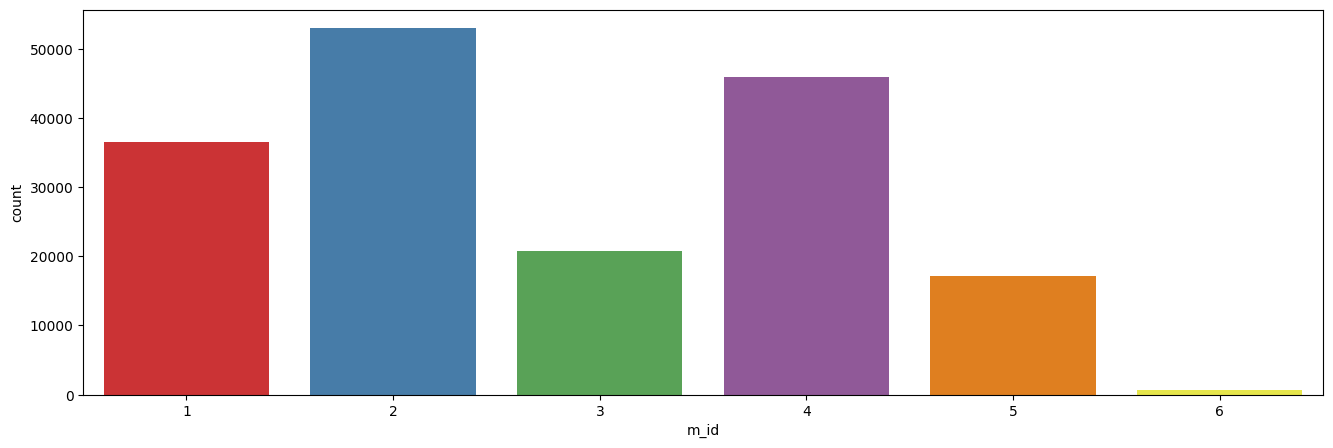

In [23]:
temp=pd.DataFrame(np.round(df['m_id'].value_counts(normalize=True)*100,2).sort_index())
display(temp.rename(columns={'m_id':'Percentage'}).T)

plt.figure(figsize=(16,5))
sns.countplot(data=df,x='m_id', palette='Set1')
plt.show()

Observation - Most of the orders were placed from market_place 2,4 and 1.

### 2) Distribution of Order_Type.

orderType,1,2,3,4,5,6,7
proportion,27.64,12.0,27.02,9.3,23.65,0.39,0.01


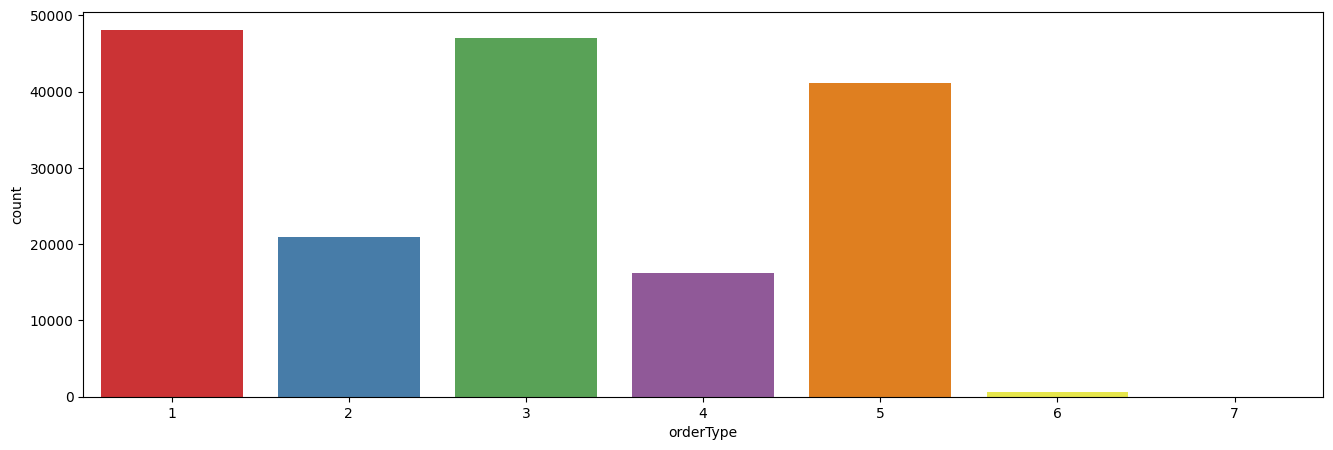

In [24]:
# order_type : integer code for how the order was placed - through porter, call to restaurant, pre booked, third partzzz etc

temp=pd.DataFrame(np.round(df['orderType'].value_counts(normalize=True)*100,2).sort_index())
display(temp.rename(columns={'orderType':'Percentage'}).T)

plt.figure(figsize=(16,5))
sns.countplot(data=df,x='orderType',palette = "Set1")
plt.show()

Observation - Most of the orders were placed through order_type 1,3 and 5.

### 3) Distribution of Store_Category for top 10 categories.

storeCat,american,pizza,mexican,burger,sandwich,chinese,japanese,dessert,italian,indian
proportion,10.39,9.02,8.89,5.69,5.17,4.91,4.71,4.63,3.74,3.66


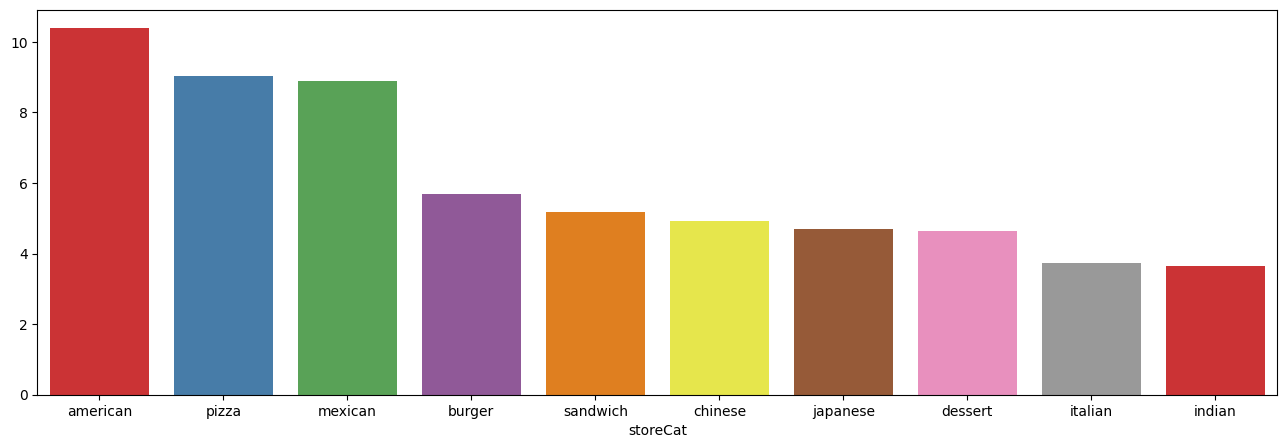

In [25]:
temp=pd.DataFrame(np.round(df['storeCat'].value_counts(normalize=True)*100,2))[:10]
display(temp.rename(columns={'storeCat':'Percentage'}).T)

plt.figure(figsize=(16,5))
sns.barplot(x=temp.index,y=temp.values.flatten(), palette="Set1")
plt.show()

Observation - The top Store_Categories are "american", "pizza" and "mexican".

### 4) Distribution of Hour.

hour,0,1,2,3,4,5,6,7,8,14,15,16,17,18,19,20,21,22,23
proportion,6.51,14.64,18.73,13.47,7.5,3.41,0.68,0.01,0.0,0.02,0.28,1.1,1.73,2.59,6.93,7.97,5.83,4.46,4.16


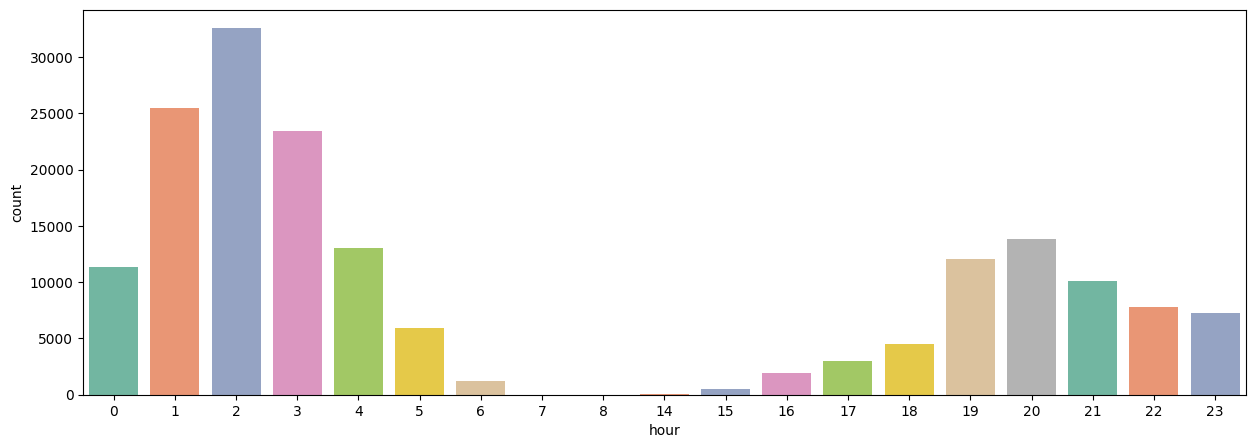

In [26]:
temp=pd.DataFrame(np.round(df['hour'].value_counts(normalize=True)*100,2).sort_index())
display(temp.rename(columns={'hour':'Percentage'}).T)

plt.figure(figsize=(15,5))
sns.countplot(data=df,x='hour', palette="Set2")
plt.show()

Observation - There is a huge fall in orders_placed between 6 and 15 hours.

### 5) Distribution of Day.

day,0,1,2,3,4,5,6
proportion,13.74,12.18,12.36,13.05,14.2,17.51,16.96


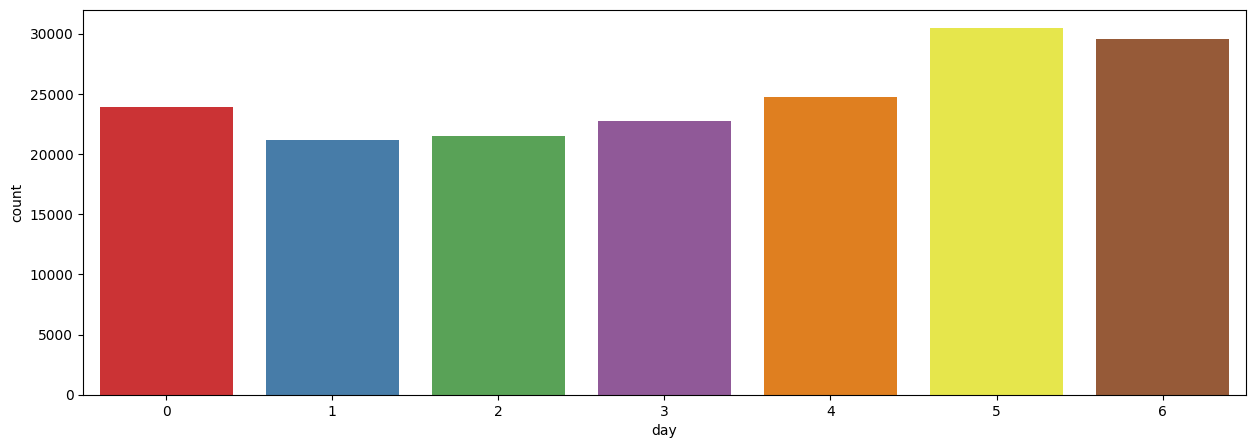

In [27]:
temp=pd.DataFrame(np.round(df['day'].value_counts(normalize=True)*100,2).sort_index())
display(temp.rename(columns={'day':'Percentage'}).T)

plt.figure(figsize=(15,5))
sns.countplot(data=df,x='day', palette="Set1")
plt.show()

Observation - Highest number of orders were placed on weekends(5-Saturday,6-Sunday).

### 6) Distribution of Total_Items.

totalItems,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
proportion,20.54,28.13,20.09,12.89,7.14,4.37,2.51,1.5,0.91,0.6,0.38,0.31,0.16,0.13,0.09,0.06,0.05,0.04,0.02,0.01


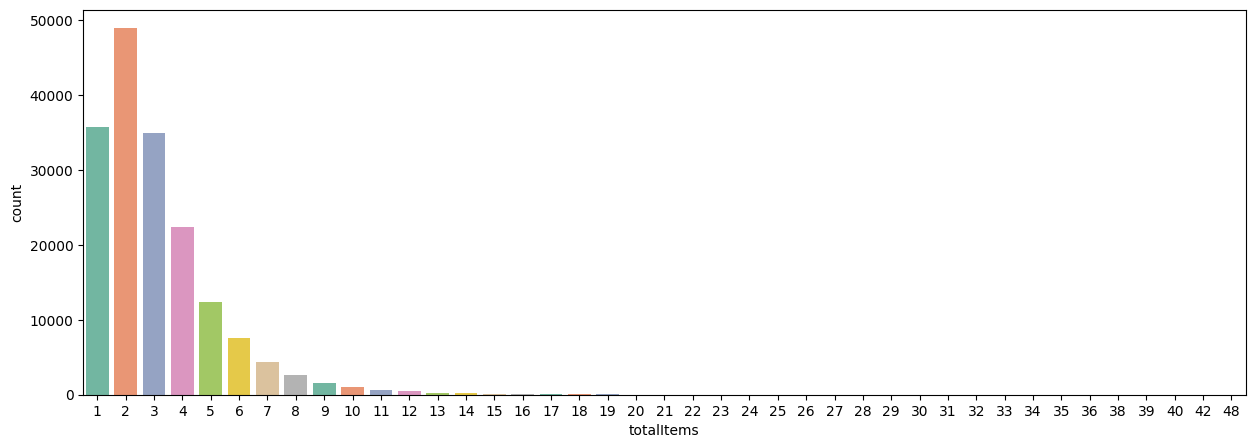

In [28]:
temp=pd.DataFrame(np.round(df['totalItems'].value_counts(normalize=True)*100,2).sort_index())[:20]
display(temp.rename(columns={'totalItems':'Percentage'}).T)

plt.figure(figsize=(15,5))
sns.countplot(data=df,x='totalItems', palette="Set2")
plt.show()

Observation - Orders having total_items more than 20 are very few.

We can remove these records.


In [29]:
df=df[df['totalItems']<=20].reset_index(drop=True)

### 7) Distribution of SubTotal.

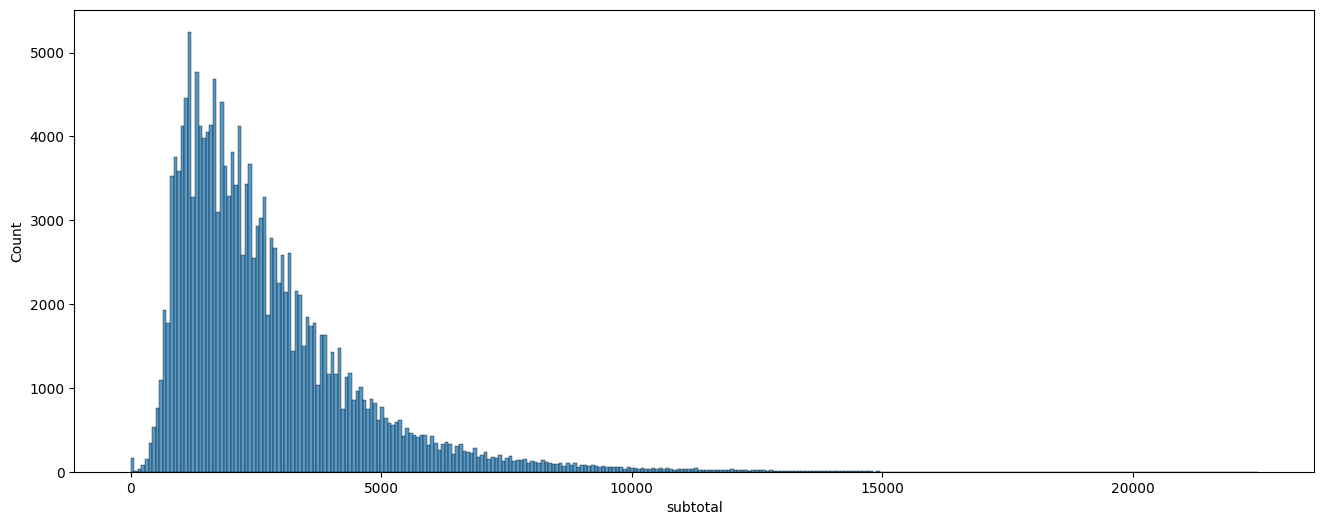

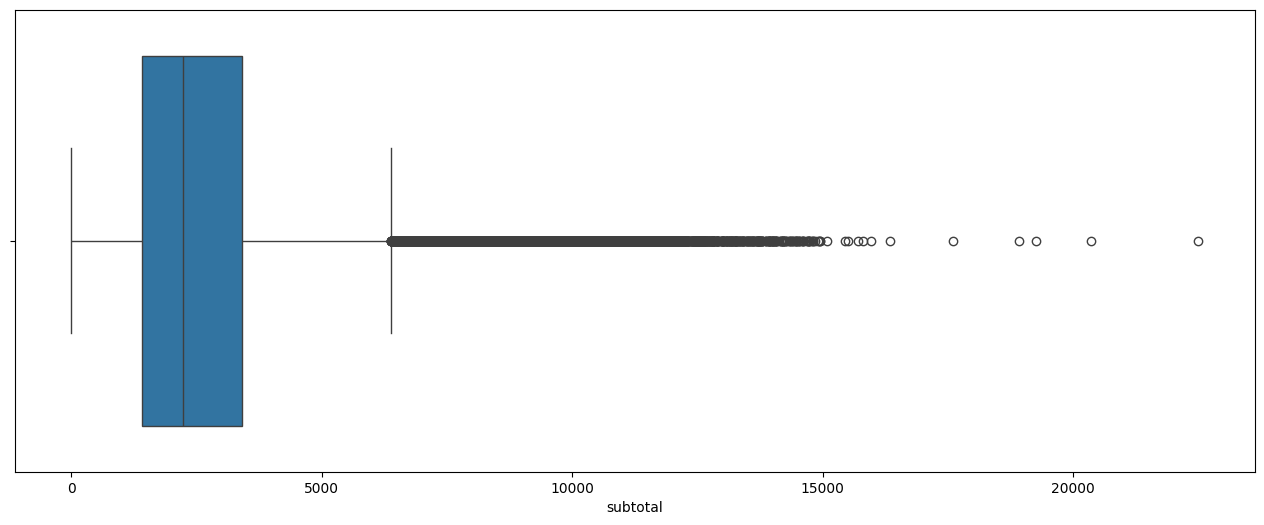

In [30]:
plt.figure(figsize=(16,6))
sns.histplot(data=df,x='subtotal')
plt.show()

plt.figure(figsize=(16,6))
sns.boxplot(data=df,x='subtotal')
plt.show()

Observation - Data is heavily Right Skewed.

There are big outliers as large as 2,00,000. We can try doing Log tranformation.

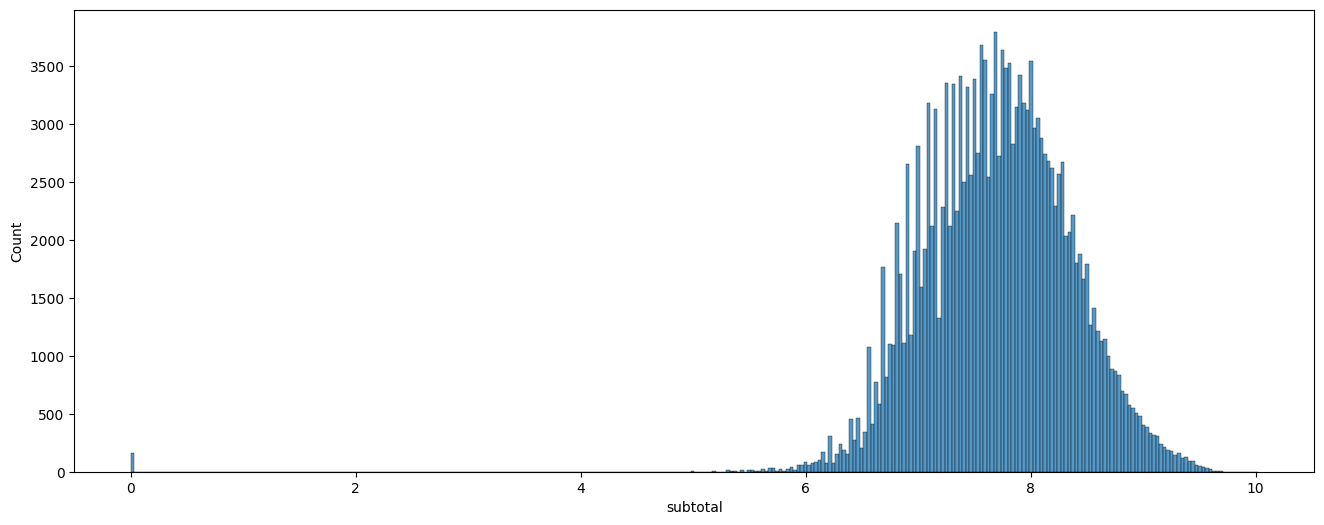

In [31]:
df['subtotal']=np.log(df['subtotal']+1)

plt.figure(figsize=(16,6))
sns.histplot(data=df,x='subtotal')
plt.show()

There are few outliers on the left at value 0. We can remove them.

In [32]:
df=df[df['subtotal']>0].reset_index(drop=True)

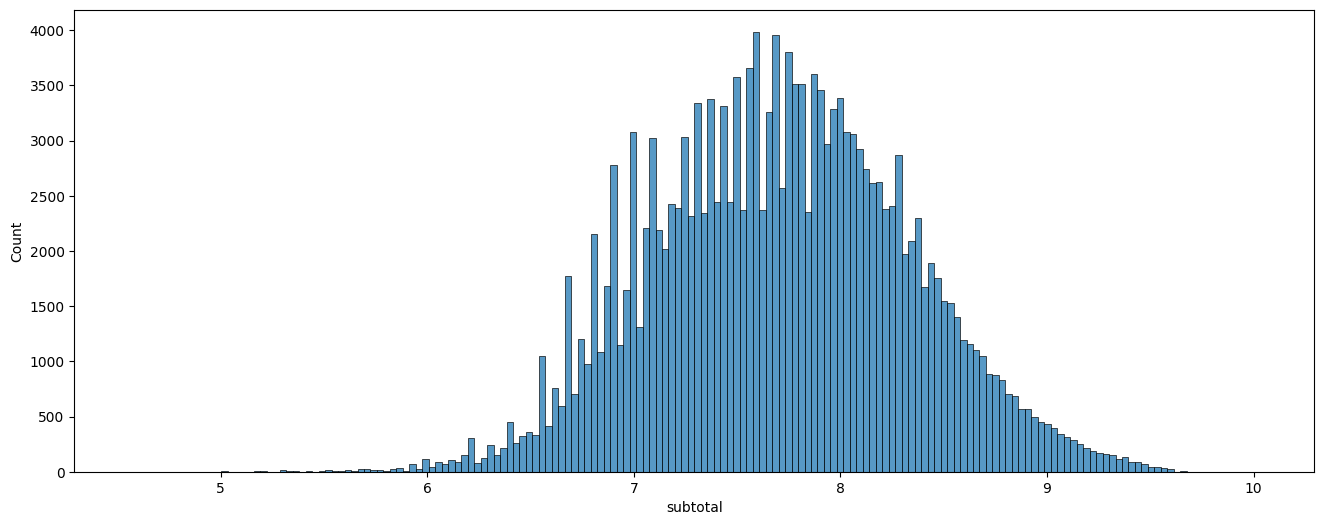

In [33]:
# Histogram after Transformation and removing Outliers.

plt.figure(figsize=(16,6))
sns.histplot(data=df,x='subtotal')
plt.show()

### 8) Distribution of Delivery_Time.

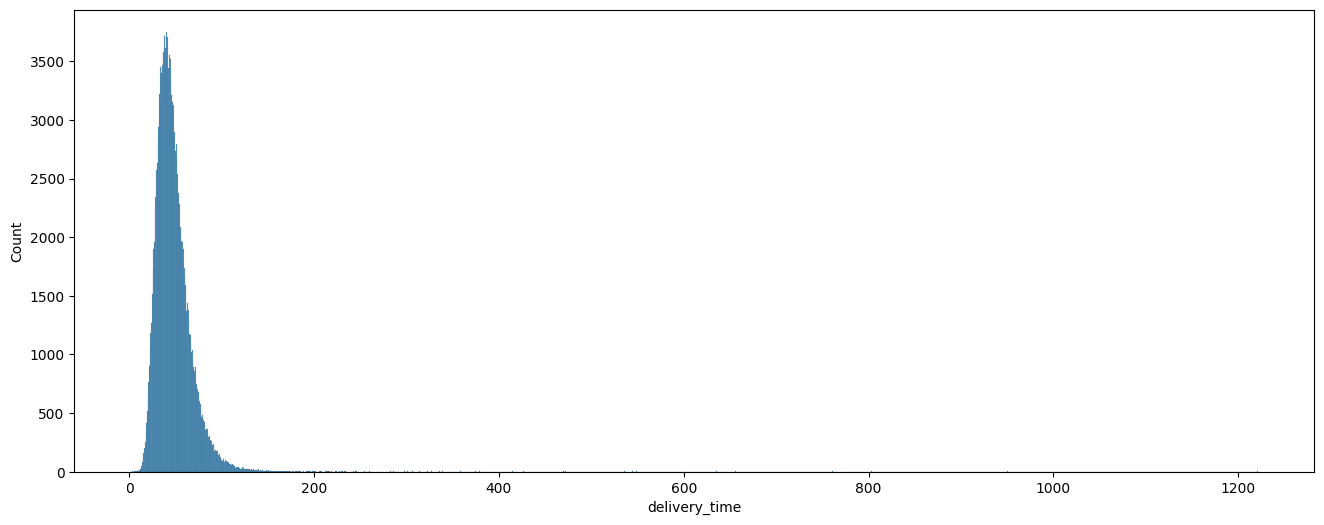

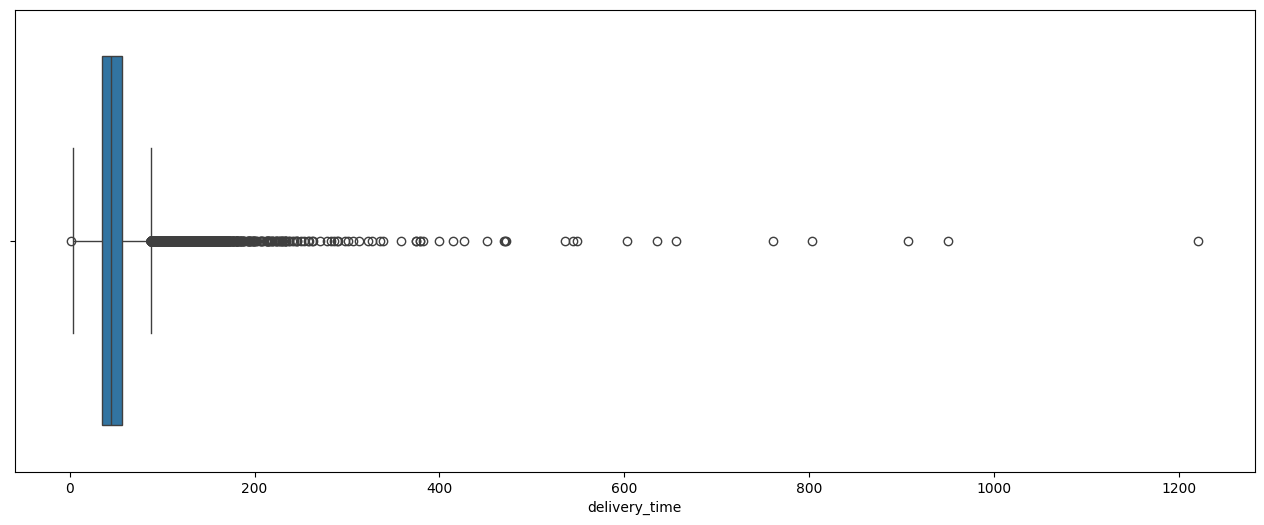

In [34]:
plt.figure(figsize=(16,6))
sns.histplot(data=df,x='delivery_time')
plt.show()

plt.figure(figsize=(16,6))
sns.boxplot(data=df,x='delivery_time')
plt.show()

Observation - Data is heavily Right Skewed and there are big outliers.

Delivery_time more than 2 hours doesn't seem reasonable.We can remove records which have delivery_time more than 120 mins.

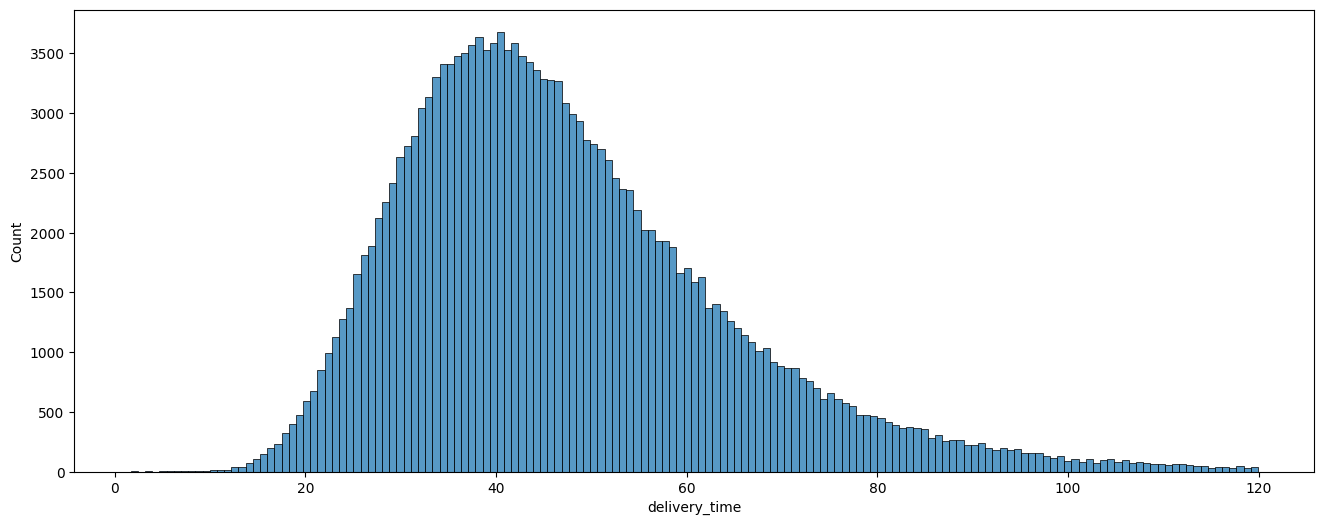

In [35]:
df=df[df['delivery_time']<=120].reset_index(drop=True)

plt.figure(figsize=(16,6))
sns.histplot(data=df,x='delivery_time')
plt.show()

### 9) Distribution of  Total_Items vs Subtotal.

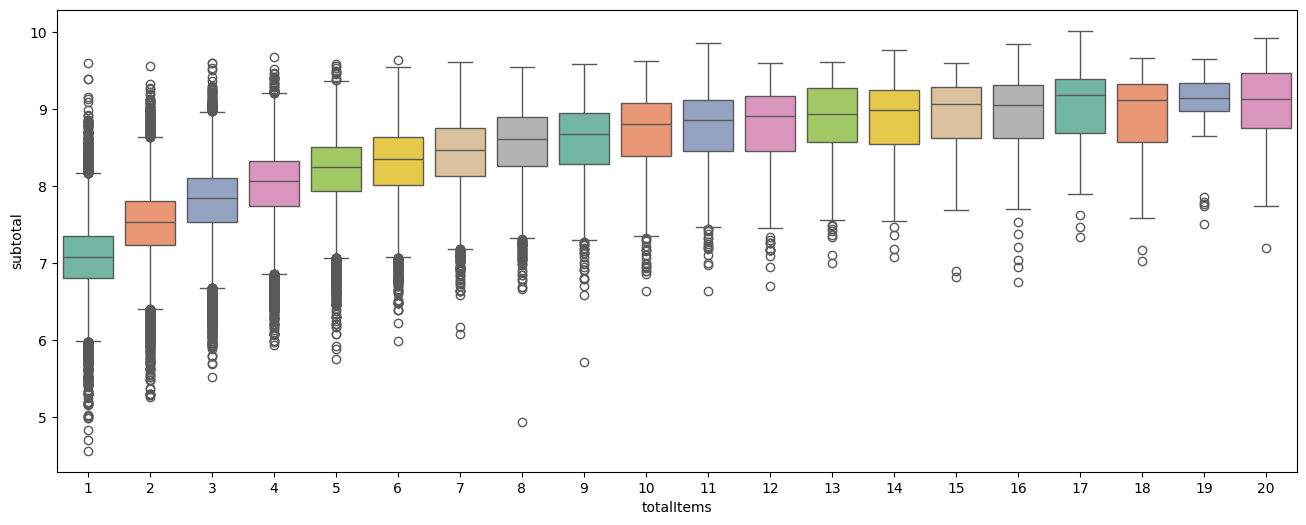

In [36]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df,x='totalItems',y='subtotal', palette="Set2")
plt.show()

Observation - With increase in total_items, median subtotal is also increasing.

### 10) Distribution of total_items vs delivery_time.

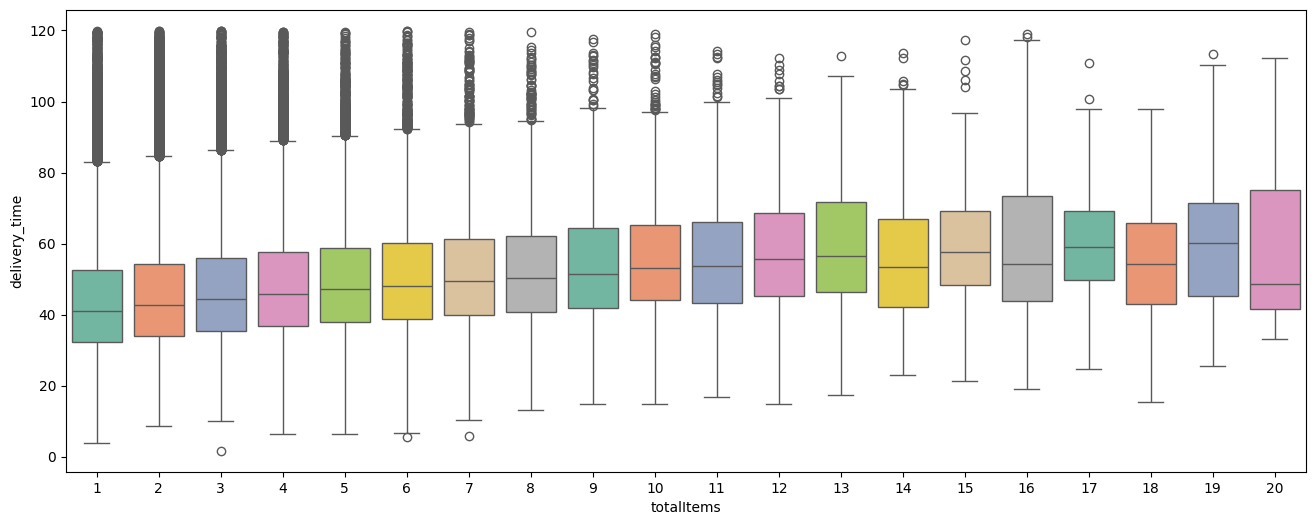

In [37]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df,x='totalItems',y='delivery_time', palette="Set2")
plt.show()

### 11) Distribution of Market_Id vs delivery_time.

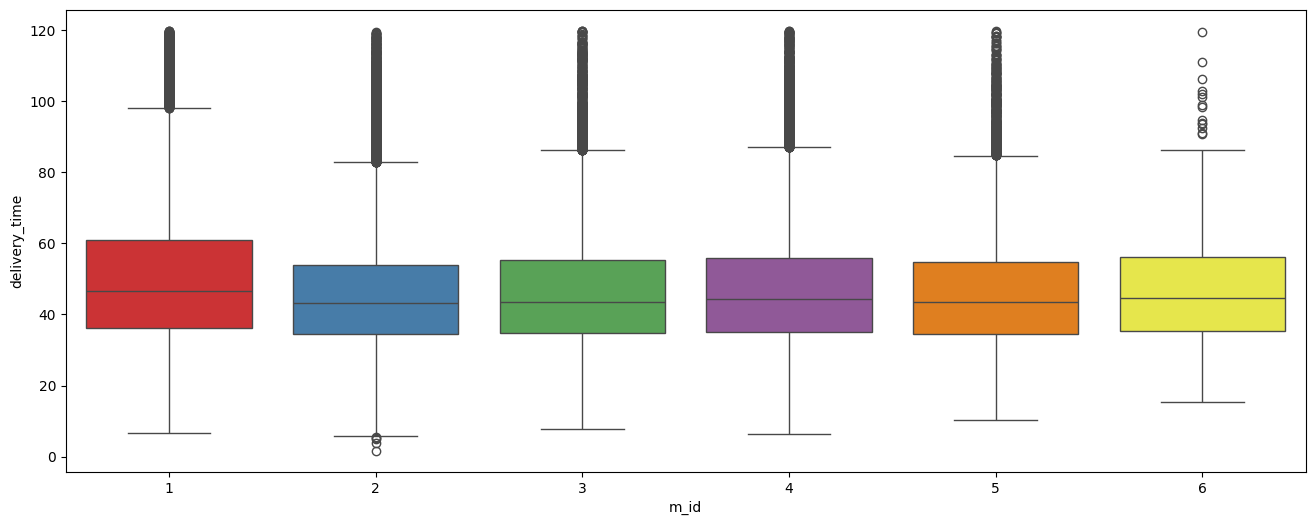

In [38]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df,x='m_id',y='delivery_time', palette="Set1")
plt.show()

Median_Delivery time for the different markets are almost the same, except market_id 1.

### 12) Distribution of order_type vs delivery_time.

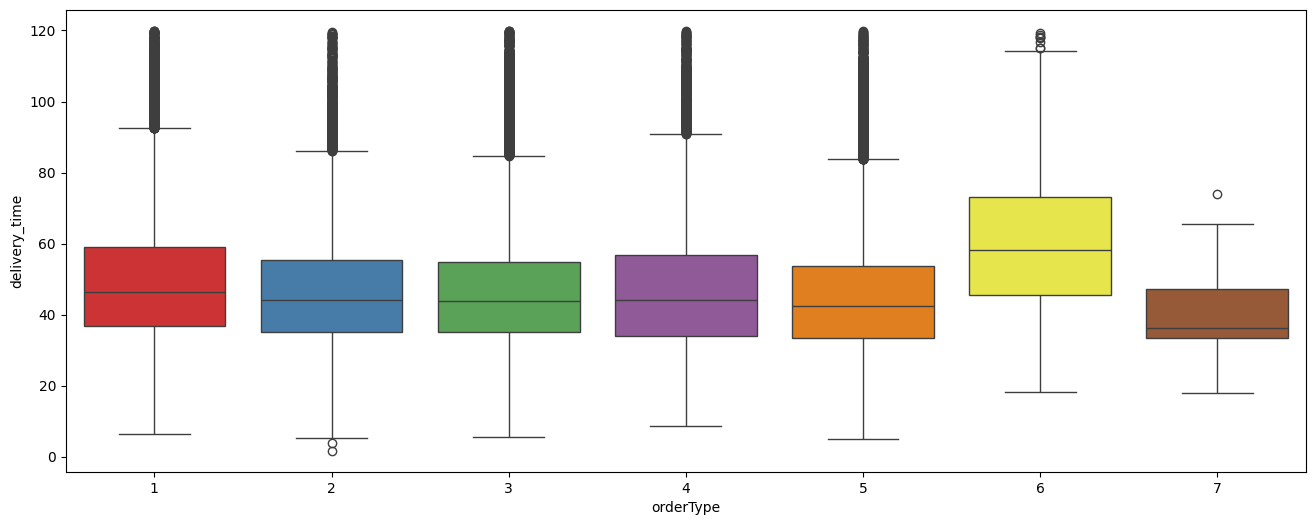

In [39]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df,x='orderType',y='delivery_time', palette="Set1")
plt.show()

Median_Delivery time for the different order_types are almost the same, except order_type 6.

### 13) Distribution of delivery_time vs subtotal.

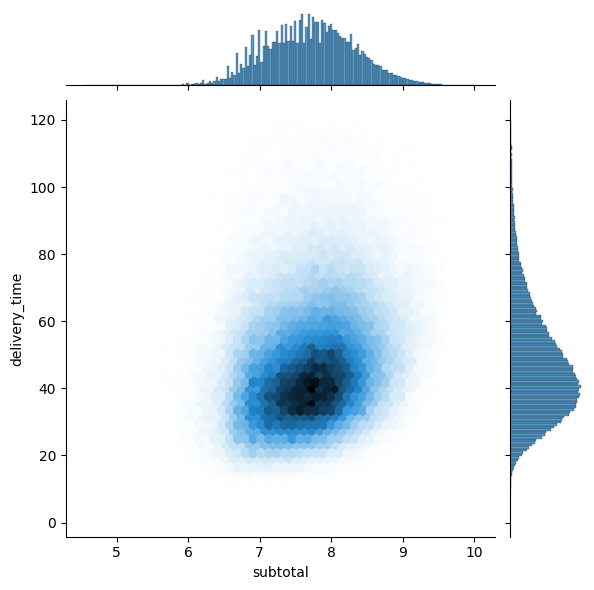

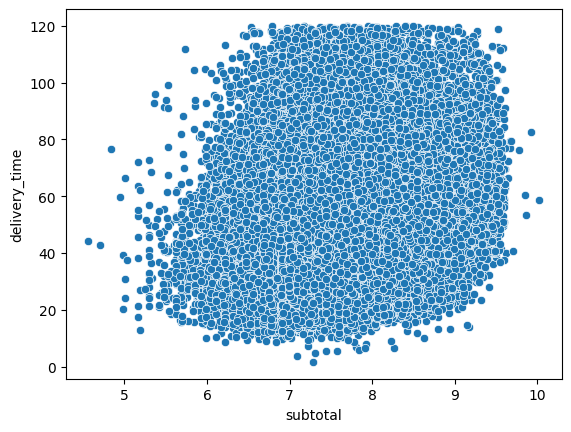

In [40]:
sns.jointplot(data=df,x='subtotal',y='delivery_time',kind='hex')
plt.show()
sns.scatterplot(data=df,x='subtotal',y='delivery_time')
plt.show()

Observation - We don't see a pattern between subtotal and delivery_time.

# Final Sanity Check

In [41]:
# We can drop "storeId" column because of the large number of categories, which can lead to curse of dimensionlaity.
df.drop(columns=['storeId'],inplace=True)

In [42]:
df.head()

,m_id,storeCat,orderType,totalItems,subtotal,distinctItems,minItemPrice,maxItemPrice,onshift_p,busy_p,outstandingOrders,delivery_time,hour,day
0,1,american,1,4,8.143808,4,557,1239,33,14,21,62.98,22,4
1,2,mexican,2,1,7.550135,1,1400,1400,1,2,2,67.07,21,1
2,2,indian,3,4,8.470521,3,820,1604,8,6,18,26.43,0,0
3,1,italian,1,1,7.330405,1,1525,1525,5,6,8,37.88,3,3
4,1,italian,1,2,8.194506,2,1425,2195,5,5,7,49.80,2,1


In [43]:
df.shape

(172737, 14)

In [44]:
df.isna().sum()

m_id                 0
storeCat             0
orderType            0
totalItems           0
subtotal             0
distinctItems        0
minItemPrice         0
maxItemPrice         0
onshift_p            0
busy_p               0
outstandingOrders    0
delivery_time        0
hour                 0
day                  0
dtype: int64

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172737 entries, 0 to 172736
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   m_id               172737 non-null  int64  
 1   storeCat           172737 non-null  object 
 2   orderType          172737 non-null  int64  
 3   totalItems         172737 non-null  int64  
 4   subtotal           172737 non-null  float64
 5   distinctItems      172737 non-null  int64  
 6   minItemPrice       172737 non-null  int64  
 7   maxItemPrice       172737 non-null  int64  
 8   onshift_p          172737 non-null  int64  
 9   busy_p             172737 non-null  int64  
 10  outstandingOrders  172737 non-null  int64  
 11  delivery_time      172737 non-null  float64
 12  hour               172737 non-null  int64  
 13  day                172737 non-null  int64  
dtypes: float64(2), int64(11), object(1)
memory usage: 18.5+ MB


# Encoding

Need to One_Hot_Encode:
- "storeCat"
- "orderType"
- "hour"
- "day"

In [46]:
# For tree based models, we should not do OHE for categorical features. We can therefore use OrdinalEncoding.

df_tree=df.copy()
ordinal=OrdinalEncoder(dtype='int64')
ordinal_transformed=ordinal.fit_transform(df_tree[['storeCat']])
df_tree['storeCat']=ordinal_transformed

# Train_Test_Split

In [47]:
# Keeping 10% data for test_date to report an unbiased estimate.

X=df_tree.drop(columns=['delivery_time'])
y=df_tree['delivery_time']
X_train_dev,X_test,y_train_dev,y_test=train_test_split(X,y,test_size=0.1,random_state=1)

In [48]:
print('X_train_dev Size:',X_train_dev.shape)
print('X_test Size:',X_test.shape)

X_train_dev Size: (155463, 13)
X_test Size: (17274, 13)


# Model 1 - Random Forests

In [49]:
def evaluate(y_actual,y_pred):

    mape_score = mape(y_actual,y_pred,)
    mse_score = mse(y_actual,y_pred)
    mae_score = mae(y_actual,y_pred)

    print('Model Performance')
    print('MAPE',round(mape_score,2))
    print('MSE',round(mse_score,2))
    print('MAE',round(mae_score,2))

In [50]:
param_grid = {'max_depth': [20,30,40,50]}
rf_model = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv = 2, n_jobs = -1)
grid_search.fit(X_train_dev, y_train_dev)

y_pred=grid_search.predict(X_test)
evaluate(y_test,y_pred)

Model Performance
MAPE 0.26
MSE 203.66
MAE 10.89


# Model 2 -  GBDT

In [51]:
param_grid = {'max_depth': [10,15,20,25]}
rf_model = GradientBoostingRegressor()

grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv = 2, n_jobs = -1)
grid_search.fit(X_train_dev, y_train_dev)

y_pred=grid_search.predict(X_test)
evaluate(y_test,y_pred)

Model Performance
MAPE 0.25
MSE 192.2
MAE 10.55


# Model 3 - Neural Networks

Need to One_Hot_Encode:
- "storeCat"
- "orderType"
- "hour"
- "day"

In [52]:
# For Neural Networks, we should do OneHotEncoding for categorical features.

df_nn=df.copy()
ohe=OneHotEncoder(drop='first',sparse=False,dtype='int64')
ohe_transformed=ohe.fit_transform(df_nn[['storeCat','orderType','hour','day']])
df_nn.drop(columns=['storeCat','orderType','hour','day'],inplace=True)
temp=pd.DataFrame(data=ohe_transformed,columns=ohe.get_feature_names_out())
df_nn=pd.concat((df_nn,temp),axis=1)

# Train_Test Split

In [53]:
# Keeping 10% data for test_date to report an unbiased estimate.

X=df_nn.drop(columns=['delivery_time'])
y=df_nn['delivery_time']
X_train_dev,X_test,y_train_dev,y_test=train_test_split(X,y,test_size=0.1,random_state=1)

In [54]:
print('X_train_dev Size:',X_train_dev.shape)
print('X_test Size:',X_test.shape)

X_train_dev Size: (155463, 110)
X_test Size: (17274, 110)


In [55]:
print('y_train_dev Size:',y_train_dev.shape)
print('y_test Size:',y_test.shape)

y_train_dev Size: (155463,)
y_test Size: (17274,)


# Scaling

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_dev = scaler.fit_transform(X_train_dev)
X_test = scaler.transform(X_test)

## NN_Model 1 - Creating a simple neural network

In [57]:
model = Sequential([
                    Dense(10, activation="relu",input_shape=(110,), name="hidden_1"), #Hidden Layer has 10 neurons
                    Dense(1, activation="linear",name="output") #Output Layer has 1 neuron which predicts the Delivery Time
])

model.compile(
    optimizer = 'sgd',
    loss = "mean_squared_error",
    metrics = ["mape"])

history=model.fit(X_train_dev, y_train_dev, epochs=10, batch_size=256, validation_split=0.1, verbose=0)

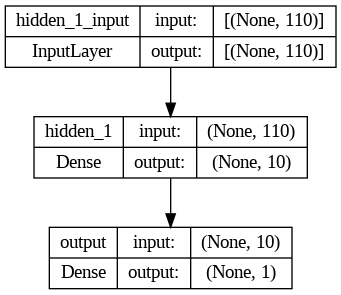

In [58]:
plot_model(model,
    to_file='model.png',
    show_shapes=True, show_layer_names=True)

In [59]:
def plot(history):

  epochs = history.epoch
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  plt.plot(epochs, loss, label="train")
  plt.plot(epochs, val_loss, label="validation")
  plt.legend()
  plt.title("MAPE VS Epochs")
  plt.show()

## NN_Model 2 - Using Adam Optimizer and More number of Neurons in Hidden Layer

In [60]:
model = Sequential([
                    Dense(100, activation="relu",input_shape=(110,), name="hidden_1"), #Hidden Layer has 100 neurons
                    Dense(1, activation="linear",name="output") #Output Layer has 1 neuron which predicts the Delivery Time
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = "mean_squared_error",
    metrics = ["mape"])

history=model.fit(X_train_dev, y_train_dev, epochs=10, batch_size=256, validation_split=0.1, verbose=0)

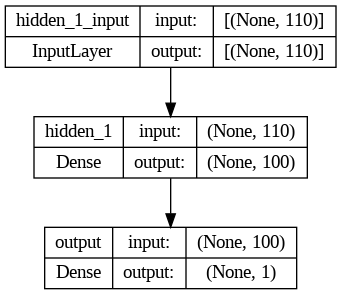

In [61]:
plot_model(model,
    to_file='model.png',
    show_shapes=True, show_layer_names=True)

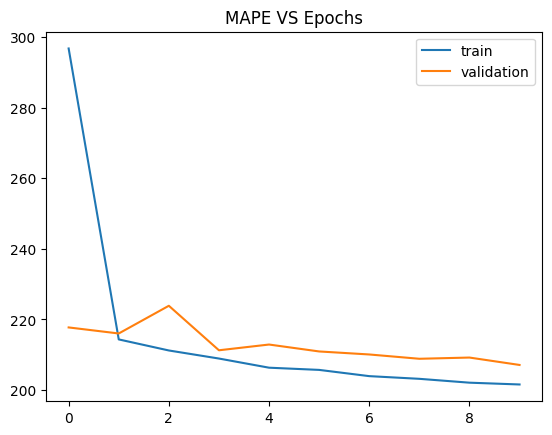

In [62]:
plot(history)

## NN_Model 3 - Using More Hidden Layers

In [63]:
model = Sequential([
                    Dense(100, activation="relu",input_shape=(110,), name="hidden_1"), #First Hidden Layer has 100 neurons
                    Dense(100, activation="relu",name="hidden_2"), #Second Hidden Layer has 100 neurons
                    Dense(100, activation="relu",name="hidden_3"), #Thied Hidden Layer has 100 neurons
                    Dense(1, activation="linear",name="output") #Output Layer has 1 neuron which predicts the Delivery Time
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = "mean_squared_error",
    metrics = ["mape"])

history=model.fit(X_train_dev, y_train_dev, epochs=10, batch_size=256, validation_split=0.1, verbose=0)# Training the neural network for required amount of epochs and plotting the losses and checking the accuracy of the model


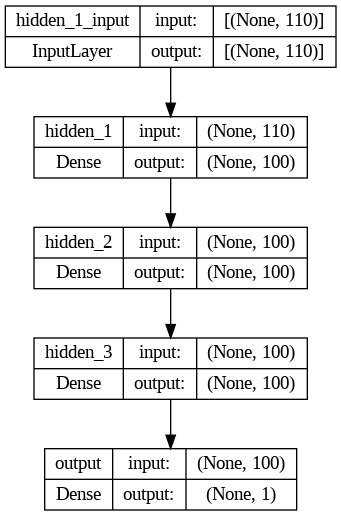

In [64]:
plot_model(model,
    to_file='model.png',
    show_shapes=True, show_layer_names=True)

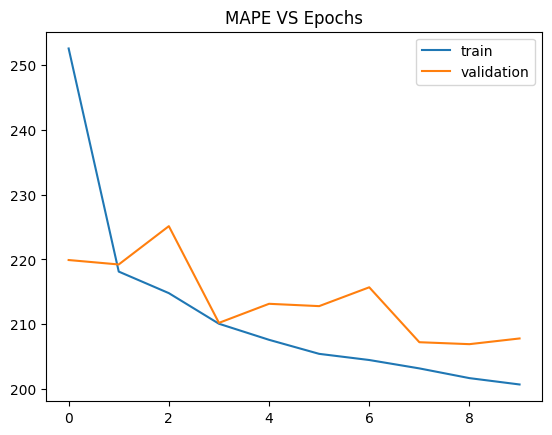

In [65]:
plot(history)

## NN_Model 4 - Using Batch Normalization

In [66]:
model = Sequential([
                    Dense(100, activation="relu",input_shape=(110,), name="hidden_1"), #First Hidden Layer has 100 neurons
                    BatchNormalization(),
                    Dense(100, activation="relu",name="hidden_2"), #Second Hidden Layer has 100 neurons
                    BatchNormalization(),
                    Dense(100, activation="relu",name="hidden_3"), #Thied Hidden Layer has 100 neurons
                    BatchNormalization(),
                    Dense(1, activation="linear",name="output") #Output Layer has 1 neuron which predicts the Delivery Time
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = "mean_squared_error",
    metrics = ["mape"])

history=model.fit(X_train_dev, y_train_dev, epochs=10, batch_size=256, validation_split=0.1, verbose=0)# Training the neural network for required amount of epochs and plotting the losses and checking the accuracy of the model


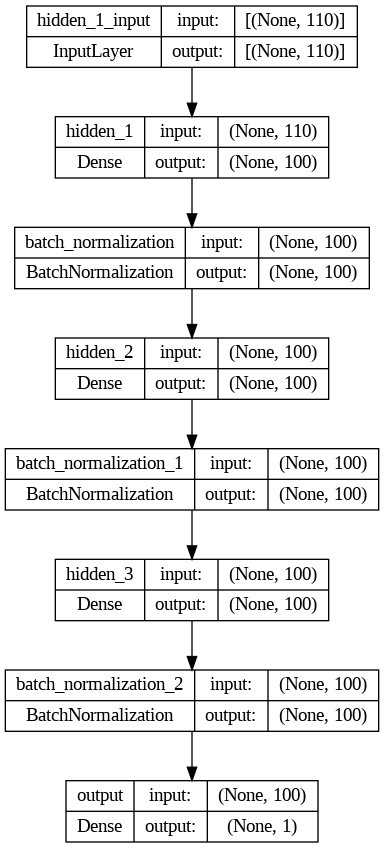

In [67]:
plot_model(model,
    to_file='model.png',
    show_shapes=True, show_layer_names=True)

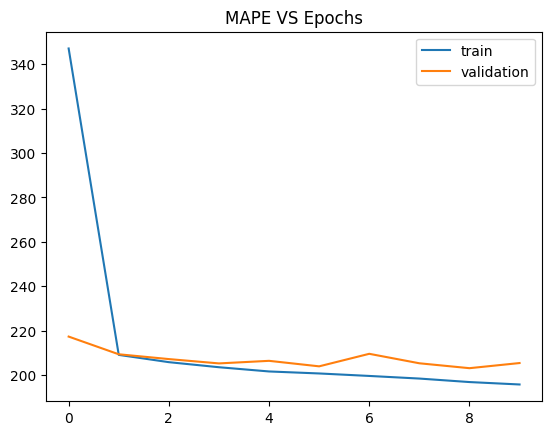

In [68]:
plot(history)

## NN_Model 5 - Increasing Number of Epochs

In [69]:
model = Sequential([
                    Dense(100, activation="relu",input_shape=(110,), name="hidden_1"), #First Hidden Layer has 100 neurons
                    BatchNormalization(),
                    Dense(100, activation="relu",name="hidden_2"), #Second Hidden Layer has 100 neurons
                    BatchNormalization(),
                    Dense(100, activation="relu", name="hidden_3"), #Thied Hidden Layer has 100 neurons
                    BatchNormalization(),
                    Dense(1, activation="linear",name="output") #Output Layer has 1 neuron which predicts the Delivery Time
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = "mean_squared_error",
    metrics = ["mape"])

history=model.fit(X_train_dev, y_train_dev, epochs=50, batch_size=256, validation_split=0.1, verbose=0)# Training the neural network for required amount of epochs and plotting the losses and checking the accuracy of the model


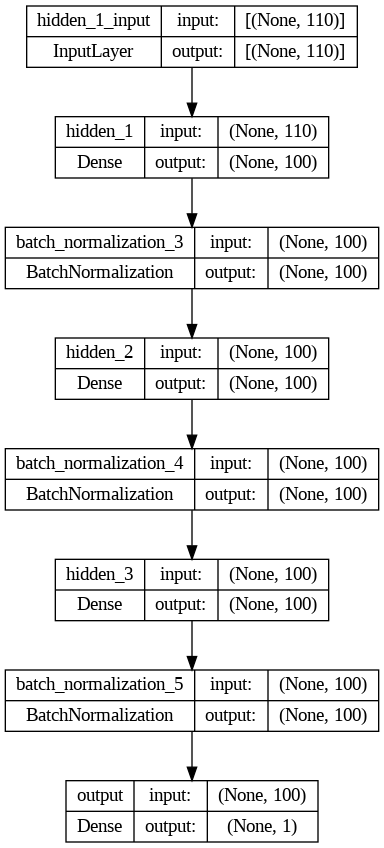

In [70]:
plot_model(model,
    to_file='model.png',
    show_shapes=True, show_layer_names=True)

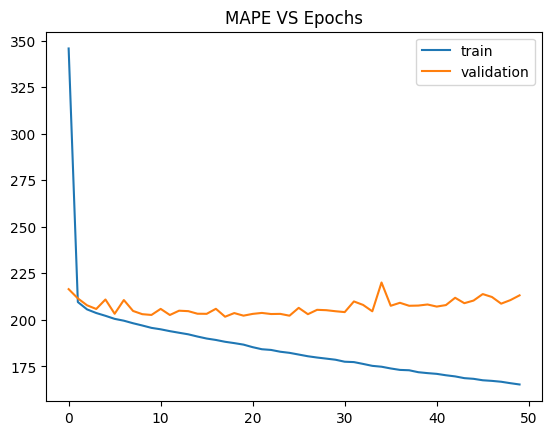

In [71]:
plot(history)

## NN_Model 6 - Using Regulazition

In [72]:
L2Reg = tf.keras.regularizers.L2(l2=1e-2)
model = Sequential([
          Dense(100, activation="relu",input_shape=(110,), name="hidden_1",kernel_regularizer = L2Reg), #First Hidden Layer has 100 neurons
          BatchNormalization(),
          Dense(100, activation="relu",input_shape=(110,), name="hidden_2",kernel_regularizer = L2Reg), #Second Hidden Layer has 100 neurons
          BatchNormalization(),
          Dense(100, activation="relu",input_shape=(110,), name="hidden_3",kernel_regularizer = L2Reg), #Thied Hidden Layer has 100 neurons
          BatchNormalization(),
          Dense(1, activation="linear",name="output") #Output Layer has 1 neuron which predicts the Delivery Time
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = "mean_squared_error",
    metrics = ["mape"])

history=model.fit(X_train_dev, y_train_dev, epochs=40, batch_size=256, validation_split=0.1, verbose=0)# Training the neural network for required amount of epochs and plotting the losses and checking the accuracy of the model


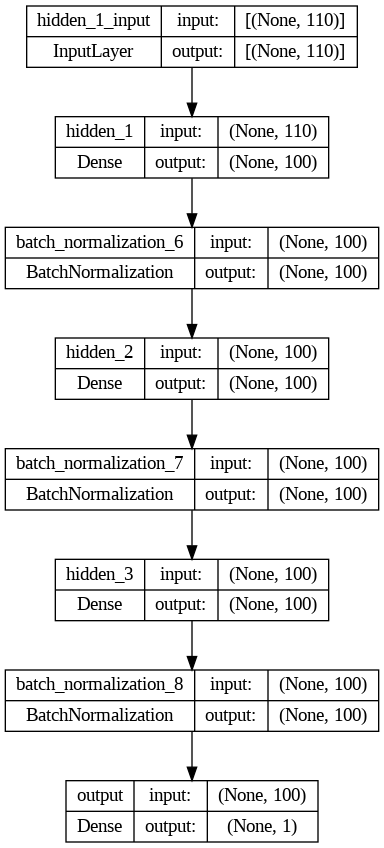

In [73]:
plot_model(model,
    to_file='model.png',
    show_shapes=True, show_layer_names=True)

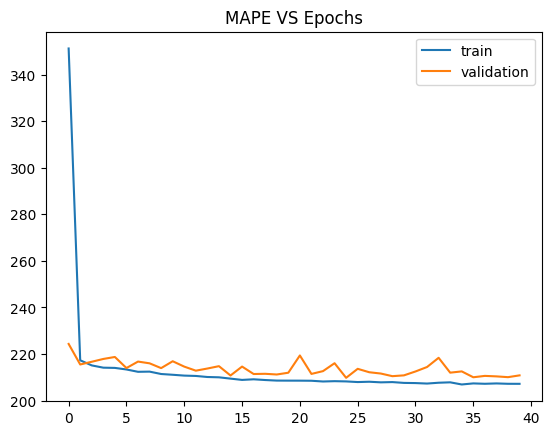

In [74]:
plot(history)

## Comparing the results of neural network and random forest

In [75]:
# Building a NN model with 32 epochs as inferred from above graph.

L2Reg = tf.keras.regularizers.L2(l2=1e-2)
model = Sequential([
          Dense(100, activation="relu",input_shape=(110,), name="hidden_1",kernel_regularizer = L2Reg), #First Hidden Layer has 100 neurons
          BatchNormalization(),
          Dense(100, activation="relu",input_shape=(110,), name="hidden_2",kernel_regularizer = L2Reg), #Second Hidden Layer has 100 neurons
          BatchNormalization(),
          Dense(100, activation="relu",input_shape=(110,), name="hidden_3",kernel_regularizer = L2Reg), #Thied Hidden Layer has 100 neurons
          BatchNormalization(),
          Dense(1, activation="linear",name="output") #Output Layer has 1 neuron which predicts the Delivery Time
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = "mean_squared_error",
    metrics = ["mape"])

history=model.fit(X_train_dev, y_train_dev, epochs=32, batch_size=256, validation_split=0.1, verbose=0)# Training the neural network for required amount of epochs and plotting the losses and checking the accuracy of the model


In [76]:
y_pred=model.predict(X_test)
print('Using Neural Network')
evaluate(y_test,y_pred)

540/540 [==============================] - 1s 2ms/step
Using Neural Network
Model Performance
MAPE 0.25
MSE 201.0
MAE 10.73


Observation - NN is giving slightly better performance than both GBDT and RF.

# Questions:

- Defining the problem statements and where can this and modifications of this be used? Need to predict delivery time of delivery riders. This can be used by Zomato and Swiggy.
- List 3 functions the pandas datetime provides with one line explanation. Extracting hour, month and subtracting dates functionality.
- Short note on datetime, timedelta, time span (period) data represented in date/time format is denoted by datetime. timedelta denotes the different between 2 datetime values. time span is the period between dates.
- Why do we need to check for outliers in our data? So that existing outliers do not create a problem for the ML model to identify the right trend.
- Name 3 outlier removal methods? - IQR Method, Isolation Forest, LOF
- What classical machine learning methods can we use other than random forest for regression? DT, Linear Regression, GBDT
- Why is scaling required for neural networks? To bring the scale of the different features to same level for smoother gradient descent.
- Briefly explain your choice of optimizer. ADAM optimizer because it has both Momentum and RMS Prop for smoother gradient descent..
- Which activation function did you use and why? Relu in hidden units for non-linearity and linear for output layer for predicting continuous values.
- Why does a neural network perform well on a large dataset? With more data, NNs tend to perform better.